In [23]:
from datetime import datetime
from metloom.pointdata import SnotelPointData
import pandas as pd

In [54]:
snotel_point = SnotelPointData("728:WA:SNTL", "MyStation")
df = snotel_point.get_hourly_data(
    datetime(2022, 7, 2), datetime(2023, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM, snotel_point.ALLOWED_VARIABLES.TEMP]
)

# Clean up the dataframe
df.reset_index(inplace=True)
df.set_index('datetime', inplace=True)
df.drop(columns=['site', 'ACCUMULATED PRECIPITATION_units', 'geometry', 'AIR TEMP_units', 'datasource'], inplace=True)

# Rename columns
replace = {'ACCUMULATED PRECIPITATION':'accppt','AIR TEMP':'airtemp'}
df.rename(columns=replace, inplace=True)

In [55]:
# Covert air temperature to celsius
df['airtemp'] = (df['airtemp'] - 32) * 5.0/9.0

# Convert precipitation to mm
df['accppt'] = df['accppt'] * 25.4

# Convert from geodataframe to dataframe
df = pd.DataFrame(df)


In [56]:
from pytz import UTC
# Interpolate the missing values
df.interpolate(inplace=True)

# Seperate the data into two dataframes, before and after October 1
a1 = df.loc[datetime(2022, 7, 2).replace(tzinfo=UTC):datetime(2022, 10, 1).replace(tzinfo=UTC)]
a2 = df.loc[datetime(2022, 10, 1).replace(tzinfo=UTC):]

# Copy the dataframe a2 to a2_copy
a2_copy = a2.copy()

# Create a mask to identify rows where the index is less than or equal to October 2, 2023
mask = a2_copy.index <= datetime(2022, 10, 2).replace(tzinfo=UTC)

# Set the 'precip_accum' column to 0 for rows that satisfy the mask condition
a2_copy.loc[mask, 'accppt'] = 0

# Update the value of a2 to the modified copy
a2 = a2_copy

# Calculate the difference between the maximum value of 'precip_accum' and the previous value
a1['accppt'] = a1['accppt'].cummax().diff()
a2['accppt'] = a2['accppt'].cummax().diff()

/var/folders/db/7c91t8d577n1zsyhth1xc7840000gn/T/ipykernel_48749/3490977852.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1['accppt'] = a1['accppt'].cummax().diff()


<Axes: xlabel='datetime'>

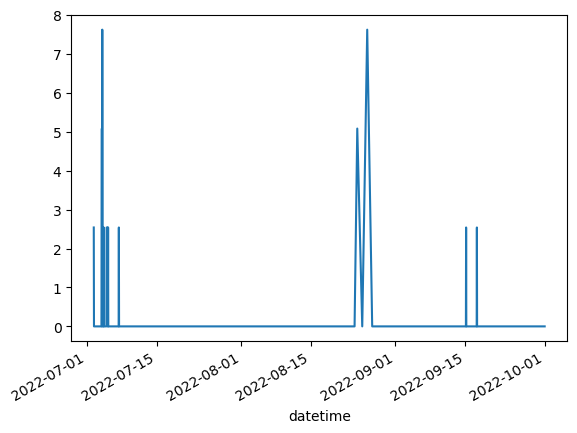

In [57]:
a1['accppt'].plot()